In [28]:
import pandas as pd
import re
import nltk
import random
import numpy as np
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt', download_dir='C:/Users/lenovo/AppData/Roaming/nltk_data')
nltk.download('stopwords', download_dir='C:/Users/lenovo/AppData/Roaming/nltk_data')
nltk.download('wordnet', download_dir='C:/Users/lenovo/AppData/Roaming/nltk_data')

# Path to data
tsv_folder = r"C:\Users\lenovo\Desktop\Subjectivity in News Articles\task1\data\english"

[nltk_data] Downloading package punkt to
[nltk_data]     C:/Users/lenovo/AppData/Roaming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:/Users/lenovo/AppData/Roaming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:/Users/lenovo/AppData/Roaming/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
train_df = pd.read_csv(r"C:\Users\lenovo\Desktop\Subjectivity in News Articles\task1\data\english/train_en.csv")
dev_df = pd.read_csv(r"C:\Users\lenovo\Desktop\Subjectivity in News Articles\task1\data\english/dev_en.csv")
test_df = pd.read_csv(r"C:\Users\lenovo\Desktop\Subjectivity in News Articles\task1\data\english/dev_test_en.csv")

train_df


,sentence_id,sentence,label,solved_conflict
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,SUBJ,True
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,OBJ,False
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,OBJ,False
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,OBJ,False
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",SUBJ,False
...,...,...,...,...
825,9a0f5eec-cc36-49b8-88eb-20ad2c056eaa,Local governments and their financing vehicles...,SUBJ,False
826,73545884-adf8-480c-a8b5-e65128ba8e91,That fact alone underscores the biggest proble...,SUBJ,False
827,a8825286-21a4-46c9-9410-c0e7e183d708,Presumably it had in mind those Russian offici...,SUBJ,False
828,c984fc97-2604-4690-a2c0-d748703663af,"From bad taxation, reckless borrowing and reck...",SUBJ,False


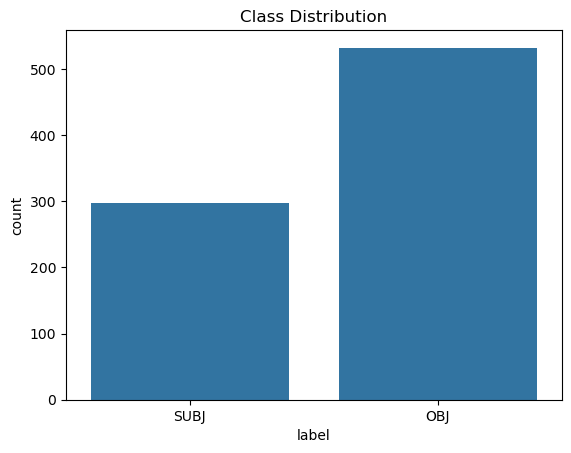

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_df)
plt.title("Class Distribution")
plt.show()


In [31]:
df = train_df.drop('solved_conflict', axis=1, inplace=False)
df

,sentence_id,sentence,label
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,SUBJ
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,OBJ
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,OBJ
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,OBJ
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",SUBJ
...,...,...,...
825,9a0f5eec-cc36-49b8-88eb-20ad2c056eaa,Local governments and their financing vehicles...,SUBJ
826,73545884-adf8-480c-a8b5-e65128ba8e91,That fact alone underscores the biggest proble...,SUBJ
827,a8825286-21a4-46c9-9410-c0e7e183d708,Presumably it had in mind those Russian offici...,SUBJ
828,c984fc97-2604-4690-a2c0-d748703663af,"From bad taxation, reckless borrowing and reck...",SUBJ


In [32]:
def clean_text(text):
    text = str(text).lower()                        # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)      # Remove URLs
    text = re.sub(r'@\w+', '', text)                # Remove mentions
    text = re.sub(r'#\w+', '', text)                # Remove hashtags
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)             # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra whitespace
    return text


In [33]:
def tokenize_text(text):
    return word_tokenize(text)

In [34]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [35]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [36]:
def preprocess_pipeline_with_pos(df):
    df['cleaned_sentence'] = df['sentence'].apply(clean_text)
    df['tokens'] = df['cleaned_sentence'].apply(tokenize_text)
    df['no_stopwords'] = df['tokens'].apply(remove_stopwords)
    df['lemmatized'] = df['no_stopwords'].apply(lemmatize_tokens)
    df['final_text'] = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))
    return df

In [37]:
train_df = preprocess_pipeline_with_pos(train_df)
dev_df = preprocess_pipeline_with_pos(dev_df)
test_df = preprocess_pipeline_with_pos(test_df)


In [13]:
def augment_minority_classes(df):
    label_counts = df['label'].value_counts()
    max_count = label_counts.max()

    augmented_rows = []

    for label, count in label_counts.items():
        if count < max_count:
            subset = df[df['label'] == label]
            needed = max_count - count
            for _ in range(needed):
                sample = subset.sample(n=1).iloc[0]
                tokens = sample['lemmatized']
                if len(tokens) > 1:
                    random.shuffle(tokens)
                new_text = ' '.join(tokens)
                augmented_rows.append({'sentence': sample['sentence'],
                                       'label': sample['label'],
                                       'final_text': new_text,
                                       'lemmatized': tokens})
    
    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df, augmented_df], ignore_index=True)

In [38]:
train_df = augment_minority_classes(train_df)

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

X_train = vectorizer.fit_transform(train_df['final_text']).toarray()
X_dev = vectorizer.transform(dev_df['final_text']).toarray()
X_test = vectorizer.transform(test_df['final_text']).toarray()

In [40]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df['label'])
y_dev = label_encoder.transform(dev_df['label'])
y_test = label_encoder.transform(test_df['label'])

print("Train:", X_train.shape, "Dev:", X_dev.shape, "Test:", X_test.shape)

Train: (1064, 5000) Dev: (462, 5000) Test: (484, 5000)


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=1, metric='cosine')  # You can also try 'euclidean'

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')

# Output the scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-Validation Scores: [0.77464789 0.77464789 0.78873239 0.87323944 0.8254717 ]
Mean Accuracy: 0.8073478607494021
Standard Deviation: 0.03782931499294936
